In [1]:
import numpy as np
from pydub import AudioSegment  # 10s --> 10*1000 pydub音频分割(加工音频)
import random
import sys
import io
import os
import glob
import IPython
os.chdir('./5-3/Trigger word detection/')
from td_utils import *

In [15]:
IPython.display.Audio('./raw_data/activates/1.wav')

### about the data

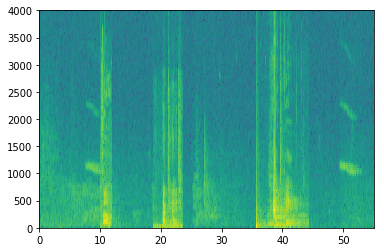

In [3]:
x = graph_spectrogram('audio_examples/example_train.wav')   # 10s --> 5511 频谱图(输入X)

In [9]:
rate, data = get_wav_info('./audio_examples/example_train.wav') # 10s --> 10*44100 原音(录制)
print(f'data.shape = {data.shape}')
print(f'x.shape = {x.shape}')

data.shape = (441000, 2)
x.shape = (101, 5511)


In [11]:
Tx = x.shape[1]
n_freq = x.shape[0]
Ty = 1375

In [12]:
activates, negatives, backgrounds = load_raw_audio()
print(f'len(background) = {len(backgrounds[0])}')
print(f'len(activate) = {len(activates[0])}')
print(f'len(negatives) = {len(negatives[0])}')

len(background) = 10000
len(activate) = 721
len(negatives) = 360


### random time segment

In [17]:
def get_random_time_segment(segment_ms):

    '''return segment_time - (segment_start, segment_end)'''

    segment_start = np.random.randint(0, 10000-segment_ms)
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

### check overlapping

In [18]:
def is_overlapping(segment_time, previous_segments):

    '''return bool'''

    segment_start, segment_end = segment_time
    overlap = False
    for pre_start, pre_end in previous_segments:
        if segment_start <= pre_end and segment_end >= pre_start:
            overlap = True
            break
    return overlap

### insert one clip to a example

In [21]:
def insert_audio_clip(background, audio_clip, pre_segments):

    '''return new_background
    when insert, try to insert utill do successfully'''

    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    while is_overlapping(segment_time, pre_segments):
        segment_time = get_random_time_segment(segment_ms)
    pre_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position=segment_time[0])

    return new_background, segment_time

In [22]:
np.random.seed(5)
new_background, segment_time = insert_audio_clip(backgrounds[0], activates[0], pre_segments=[(3790, 4400)])
new_background.export('insert_test.wav', format='wav')
print(f'segment time: {segment_time}')

segment time: (2915, 3635)


### at the same time, update labels y

In [28]:
def insert_ones(y, segment_end_ms):

    '''y - (None, Ty), ndarray
    return y'''

    segment_end_y = int(Ty * segment_end_ms / 10000.)
    start = segment_end_y + 1   # inclusive
    end = min(segment_end_y + 51, Ty)    # exclusive
    y[0, start: end] = 1

    return y

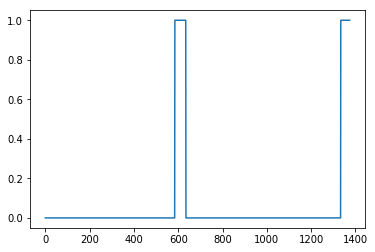

In [29]:
a1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(a1, 4251)[0, :])

### create a (x, y) pair

In [43]:
def create_training_example(background, activates, negatives):

    '''create one sample
    return x - spectrogram array(n_freq, Tx)
    y - ndarray(1, Ty)'''

    np.random.seed(18)
    background -= 20
    y = np.zeros((1, Ty))
    pre_segments = []

    n_activates = np.random.randint(0, 5)
    random_activates = np.random.choice(activates, size=n_activates)

    for audio_clip in random_activates:
        background, segment_time = insert_audio_clip(background, audio_clip, pre_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end)

    n_negatives = np.random.randint(0, 3)
    random_negatives = np.random.choice(negatives, size=n_negatives)

    for audio_clip in random_negatives:
        background, _ = insert_audio_clip(background, audio_clip, pre_segments)

    background = match_target_amplitude(background, -20.)
    file_ = background.export('train.wav', format='wav')
    print('train example saved.')

    x = graph_spectrogram('train.wav')  # (n_freq, Tx)

    return x, y

train example saved.


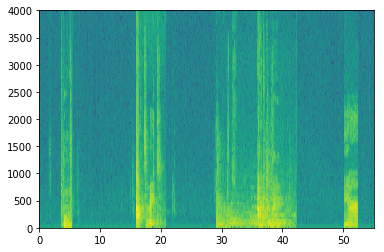

In [44]:
x, y = create_training_example(backgrounds[0], activates, negatives)

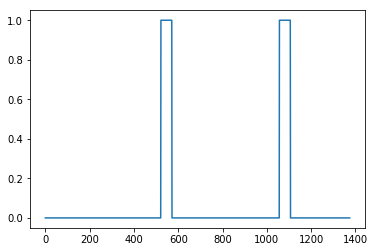

In [45]:
plt.plot(y[0])

### load train set and dev set

In [46]:
X = np.load('./XY_train/X.npy')
Y = np.load('./XY_train/Y.npy')
X_dev = np.load('./XY_dev/X_dev.npy')
Y_dev = np.load('./XY_dev/Y_dev.npy')
print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')
print(f'X_dev.shape = {X_dev.shape}')
print(f'Y_dev.shape = {Y_dev.shape}')

X.shape = (26, 5511, 101)
Y.shape = (26, 1375, 1)
X_dev.shape = (25, 5511, 101)
Y_dev.shape = (25, 1375, 1)


In [47]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

### build trigger word detect model
use Conv1D to feed GRU(/RNN/LSTM)

In [50]:
def model(input_shape=(5511, 101)):

    '''return trigger_model'''

    x_input = Input(input_shape)    # (None, 5511, 101)
    
    x = Conv1D(196, 15, strides=4)(x_input)  # (None, 1375, 196)  # 1375 = (5511-15) / 4 + 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.8)(x)

    x = GRU(128, return_sequences=True)(x)  # (None, 1375, 128)
    x = Dropout(0.8)(x)
    x = BatchNormalization()(x)

    x = GRU(128, return_sequences=True)(x)  # (None, 1375, 128)
    x = Dropout(0.8)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)

    x = TimeDistributed(Dense(1, activation='sigmoid'))(x)  # (None, 1375, 1)

    trigger_model = Model(inputs=x_input, outputs=x)

    return trigger_model

In [51]:
trigger_model = model(input_shape=(5511, 101))
trigger_model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________

In [69]:
pretrained_model = load_model('./models/tr_model.h5')

C:\Users\Administrator\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### try to fit one epochs

In [70]:
opt = Adam(lr=0.0001, decay=0.01)
pretrained_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
pretrained_model.fit(X, Y, batch_size=5, epochs=1, callbacks=[ModelCheckpoint('./models/another.hdf5')])

Epoch 1/1
26/26 [==============================] - 21s 824ms/step - loss: 0.0639 - acc: 0.9794


In [71]:
loss, acc = pretrained_model.evaluate(X_dev, Y_dev)
print(f'loss: {loss}, acc: {acc}')

25/25 [==============================] - 3s 134ms/step
loss: 0.3179888129234314, acc: 0.9332072734832764


### predict

In [72]:
def detect_triggerword(filename, model):

    plt.subplot(2, 1, 1)
    x = graph_spectrogram(filename).T   # (n_freq, Tx) --> (Tx, n_freq)
    x = np.expand_dims(x, axis=0)   # (1, Tx, n_freq)
    pred = model.predict(x) # (1, Ty, 1)
    plt.subplot(2, 1, 2)
    plt.plot(pred[0, :, 0])
    plt.ylabel('probability')
    plt.show()

    return pred

### use prediction to add chime in audio examples

In [78]:
chime_file = 'audio_examples/chime.wav'

def chime_on_activate(filename, pred, threshold, targetfile='chime_output.wav'):

    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = pred.shape[1]
    flag = 0
    for i in range(Ty):
        if flag == 0 and pred[0, i, 0] > threshold:
            audio_clip = audio_clip.overlay(chime, position=(i/Ty) * audio_clip.duration_seconds * 1000)
            flag = i
        elif pred[0, i, 0] > threshold and i-flag > 75:
            audio_clip = audio_clip.overlay(chime, position=(i/Ty) * audio_clip.duration_seconds * 1000)
            flag = i
    audio_clip.export(targetfile, format='wav')

### test on dev examples

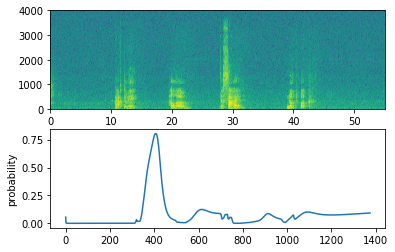

In [79]:
filename = './raw_data/dev/1.wav'
pred = detect_triggerword(filename=filename, model=pretrained_model)
chime_on_activate(filename, pred, 0.5)

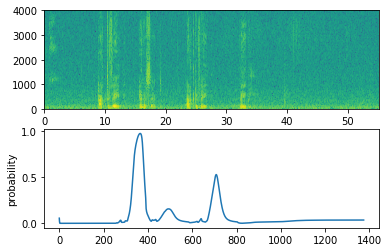

In [80]:
filename = './raw_data/dev/2.wav'
pred = detect_triggerword(filename=filename, model=pretrained_model)
chime_on_activate(filename, pred, 0.5, targetfile='chime_output2.wav')

### test myfile

In [83]:
def preprocess_audio(filename):
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    segment = segment.set_frame_rate(44100)
    segment.export(filename, format='wav')

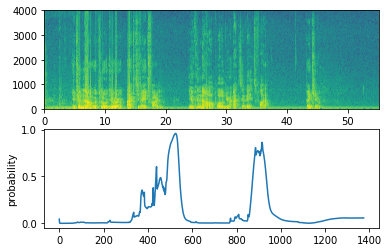

In [84]:
myfile = 'audio_examples/my_audio.wav'
preprocess_audio(myfile)
pred = detect_triggerword(filename=myfile, model=pretrained_model)
chime_on_activate(myfile, pred, 0.5, targetfile='my_chime_output.wav')

In [ ]:
# 在myfile上75/1375s的间隔似乎还是太密了